In [1]:
import os
import datetime
import copy

import numpy as np

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = '/media/pipeh/Data/Datasets/FaceDetection'
img_height = 33
img_width = 33
batch_size = 4096
epochs = 30
drop_last = False


data_transforms = {
    'train': A.Compose([
        A.Resize(height=img_height, width=img_width),
        A.RandomBrightnessContrast(p=1),
        A.RandomGamma(p=1),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=1),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.01, rotate_limit=15, p=1),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.Resize(height=img_height, width=img_width),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ToTensorV2(),
    ]),
}



class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img,dtype='float32')/255.)



image_datasets = {x: ImageFolder(os.path.join(data_dir, x), 
                                 transform=Transforms(data_transforms[x])) 
                  for x in ['train', 'test']}



def class_weights(ds, train=False):
    class_sample_count = np.array([len(np.where(ds.targets == t)[0]) for t in np.unique(ds.targets)])
    if train:
        weight = np.array([0.70, 0.70])# dejar 30%-70% de caras-no_caras por batch
    else:
        weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in ds.targets])
    samples_weight = torch.from_numpy(samples_weight)
    return samples_weight, class_sample_count



train_samples_weight, train_class_sample_count = class_weights(image_datasets['train'], train=True)
test_samples_weight, test_class_sample_count = class_weights(image_datasets['test'])



sampler = {'train': torch.utils.data.sampler.WeightedRandomSampler(train_samples_weight, len(train_samples_weight), replacement=False),
           'test': torch.utils.data.sampler.WeightedRandomSampler(test_samples_weight, len(test_samples_weight), replacement=False)
          }



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_sampler=torch.utils.data.BatchSampler(sampler[x], batch_size, drop_last))
              for x in ['train', 'test']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}

class_names = image_datasets['train'].classes

print(f"device: {device}")
print(f"dataset sizes {dataset_sizes}")
print(f"classes names {class_names}")
print(f"train class count {train_class_sample_count}")
print(f"test class count {test_class_sample_count}")

device: cuda
dataset sizes {'train': 1023280, 'test': 50440}
classes names ['face', 'no_face']
train class count [307245 716035]
test class count [25128 25312]


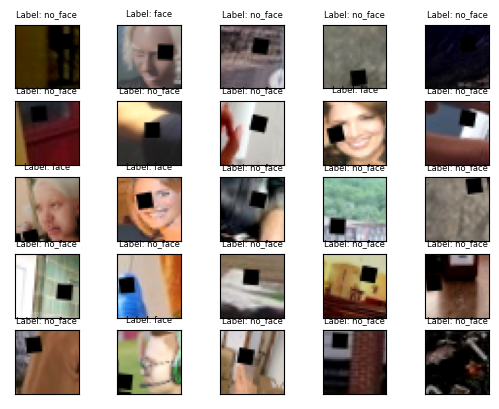

In [2]:
def view_image(ds):
    
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    
    image, label = next(iter(ds))
    image = image['image'] * std.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image + mean.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image.permute(0, 2, 3, 1).numpy()
    
    fig = plt.figure()
    for i in range(batch_size if batch_size<25 else 25):
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {class_names[label[i]]}", fontsize=6)

view_image(dataloaders['train'])

In [3]:
for i, (data, target) in enumerate(dataloaders['train']):
    print ("batch index {}, face/no_face: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))
    if i==3:
        break

batch index 0, face/no_face: 1217/2879
batch index 1, face/no_face: 1258/2838
batch index 2, face/no_face: 1276/2820
batch index 3, face/no_face: 1240/2856


In [4]:
class FaceNet(nn.Module):
    def __init__(self):
        super(FaceNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, (3, 3), stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(1152, 2)

        self.maxpool = nn.MaxPool2d(3, stride=2)
        self.dropout2d = nn.Dropout2d(0.10)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x, silent=True):
        
        silent or print(f"x: {x.shape}")
        
        x = self.conv1(x)
        x = self.dropout2d(x)
        x = self.activation(x)
        x = self.maxpool(x)
        silent or print(f"conv1: {x.shape}")
        
        x = self.conv2(x)
        x = self.dropout2d(x)
        x = self.activation(x)
        x = self.maxpool(x)
        silent or print(f"conv2: {x.shape}")
        
        x = self.conv3(x)
        x = self.dropout2d(x)
        x = self.activation(x)
        x = self.maxpool(x)
        silent or print(f"conv3: {x.shape}")
        
   
        x = nn.Flatten()(x)
        silent or print(f"flatten: {x.shape}")
        
        x = self.fc1(x)
        silent or print(f"fc1: {x.shape}")
        
        return x
    
classifier = FaceNet()
print(classifier)

FaceNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=2, bias=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (activation): LeakyReLU(negative_slope=0.1)
)


In [5]:
classifier = classifier.to(device)


lr = 0.0001
optimizer = torch.optim.Adam(
    (p for p in classifier.parameters() if p.requires_grad), lr=lr
)


criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)


print('\nStarting Training')
max_acc = 0
for epoch in range(epochs):
    
    start_time = datetime.datetime.now()
    running_loss = 0.0
    
    classifier.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        inputs = data['image'].to(device)
        labels = target.to(device)
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    predictions = torch.tensor([])
    targets = torch.tensor([])

    classifier.eval()
    for i, (data, target) in enumerate(dataloaders['test']):
        inputs = data['image'].to(device)
        labels = target
        with torch.no_grad():
            outputs = classifier(inputs)
            out = softmax(outputs)
            _, predicted = torch.max(out, 1)
        predictions = torch.cat((predictions, predicted.cpu()),0)
        targets = torch.cat((targets, labels.cpu()),0)
    
    report = classification_report(targets, predictions, target_names=class_names, digits=3, output_dict=True, zero_division=0)
    test_acc = report['accuracy']
    if test_acc >= max_acc:

        max_acc = report['accuracy']
        max_report = classification_report(targets, predictions, digits=3, target_names=class_names, zero_division=0)
        best_model_state = copy.deepcopy(classifier.state_dict())
        PATH = 'v7_faceclassifier_best.pt'
        torch.save(best_model_state, PATH)
        
    model_state = copy.deepcopy(classifier.state_dict())
    PATH = f'v7_faceclassifier_epoch{epoch}.pt'
    torch.save(model_state, PATH)
    
    n2 = datetime.datetime.now()
    elp = n2 - start_time     
    print(f'\nepoch[{epoch + 1}] --- loss: {running_loss / batch_size:.5f} --- test accuracy: {test_acc} --- elapsed time: {elp.total_seconds()}')
    print(classification_report(targets, predictions, digits=3, target_names=class_names, zero_division=0))
    
print('\nFinished Training')
print(max_report)


Starting Training

epoch[1] --- loss: 0.02931 --- test accuracy: 0.9066019032513878 --- elapsed time: 1024.583338
              precision    recall  f1-score   support

        face      0.905     0.907     0.906     25128
     no_face      0.908     0.906     0.907     25312

    accuracy                          0.907     50440
   macro avg      0.907     0.907     0.907     50440
weighted avg      0.907     0.907     0.907     50440


epoch[2] --- loss: 0.01638 --- test accuracy: 0.9558088818398097 --- elapsed time: 1090.992215
              precision    recall  f1-score   support

        face      0.955     0.956     0.956     25128
     no_face      0.956     0.955     0.956     25312

    accuracy                          0.956     50440
   macro avg      0.956     0.956     0.956     50440
weighted avg      0.956     0.956     0.956     50440


epoch[3] --- loss: 0.01183 --- test accuracy: 0.9704401268834258 --- elapsed time: 948.415665
              precision    recall  f1-sc